# **Génération d'idées de recettes selon ce que l'on a chez soi**

### Projet Python - 2A ENSAE

Projet réalisé par BRESSON Claire, CASSANT Emile, MEKKI Lila

# Introduction 

Notre objectif était de faciliter la tâche à ceux qui ne savent pas quoi manger alors que leur frigo n'est pas vide, et qui cherchent des idées de recettes à réaliser à la maison. 

# **1. Récupération des données ingrédients** 

Pour récupérer la liste des ingrédients disponibles dans la grande distribution, nous avons trouvé deux bases de données principales : l'OpenFoodFacts et Ciqual. La base de données d'OpenFoodFacts était cependant trop conséquente, donc nous avons choisi de nous concentrer sur la base Ciqual, plus petite. 

In [120]:
!pip install xlrd
!pip install unidecode
!pip install rapidfuzz
!pip install wordcloud
!pip install nltk

In [140]:
import pandas as pd 
import matplotlib.pyplot as plt
import rapidfuzz
import time
from wordcloud import WordCloud
from unidecode import unidecode
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import re # for regular expressions 
from re import sub
from functions import cleaning,trouver_correspondance_spacy2,string_to_float

In [3]:
# Lien du fichier et affichage 

data_ciqual = pd.read_excel("https://ciqual.anses.fr/cms/sites/default/files/inline-files/Table%20Ciqual%202020_FR_2020%2007%2007.xls") 
data_ciqual.head()

,alim_grp_code,alim_ssgrp_code,alim_ssssgrp_code,alim_grp_nom_fr,alim_ssgrp_nom_fr,alim_ssssgrp_nom_fr,alim_code,alim_nom_fr,alim_nom_sci,"Energie, Règlement UE N° 1169/2011 (kJ/100 g)",...,Vitamine K1 (µg/100 g),Vitamine K2 (µg/100 g),Vitamine C (mg/100 g),Vitamine B1 ou Thiamine (mg/100 g),Vitamine B2 ou Riboflavine (mg/100 g),Vitamine B3 ou PP ou Niacine (mg/100 g),Vitamine B5 ou Acide pantothénique (mg/100 g),Vitamine B6 (mg/100 g),Vitamine B9 ou Folates totaux (µg/100 g),Vitamine B12 (µg/100 g)
0,0,0,0,NaN,NaN,NaN,24999,Dessert (aliment moyen),NaN,NaN,...,NaN,NaN,"1,37","0,084","0,15","0,61","0,4","0,056","30,8","0,21"
1,1,101,0,entrées et plats composés,salades composées et crudités,-,25601,"Salade de thon et légumes, appertisée",NaN,-,...,-,-,"2,75","< 0,04","0,053","4,45","< 0,16","0,29",31,"1,45"
2,1,101,0,entrées et plats composés,salades composées et crudités,-,25602,"Salade composée avec viande ou poisson, appert...",NaN,-,...,"9,75",-,-,"0,032","0,022","4,13","0,2","0,12","11,1","1,23"
3,1,101,0,entrées et plats composés,salades composées et crudités,-,25605,"Champignons à la grecque, appertisés",NaN,-,...,-,-,"6,67","0,056","0,21","1,84","0,88","0,088","19,6","0,018"
4,1,101,0,entrées et plats composés,salades composées et crudités,-,25606,"Salade de pommes de terre, fait maison",NaN,-,...,-,-,10,"0,077","0,06","0,89","0,53","0,14",7,0


On décide de ne garder que les colonnes contenant le nom de l'aliment, son apport énérgétique, ainsi que certains substrats énergétiques courants (Glucides, Protéines,...). 

In [4]:
data_ciqual = data_ciqual[['alim_grp_nom_fr','alim_nom_fr','Energie, Règlement UE N° 1169/2011 (kJ/100 g)',
       'Energie, Règlement UE N° 1169/2011 (kcal/100 g)',
       'Protéines, N x 6.25 (g/100 g)', 'Glucides (g/100 g)',
       'Lipides (g/100 g)', 'Sucres (g/100 g)', 'Fructose (g/100 g)',
       'Glucose (g/100 g)', 'Lactose (g/100 g)','Saccharose (g/100 g)', 'Amidon (g/100 g)']]
#data_ciqual.head()

On renomme les colonnes pour plus de lisibilité.

In [5]:
new_names = {
    'alim_grp_nom_fr': 'Groupe',
    'alim_nom_fr': 'Nom aliment',
    'Energie, Règlement UE N° 1169/2011 (kJ/100 g)':'Energie kJ',
    'Energie, Règlement UE N° 1169/2011 (kcal/100 g)': 'Energie kcal',
    'Protéines, N x 6.25 (g/100 g)': 'Protéines',
    'Glucides (g/100 g)': 'Glucides',
    'Lipides (g/100 g)' : 'Lipides',
    'Sucres (g/100 g)'  : 'Sucres',
    'Fructose (g/100 g)': 'Fructose',
    'Glucose (g/100 g)' : 'Glucose',
    'Lactose (g/100 g)' : 'Lactose',
    'Saccharose (g/100 g)': 'Saccharose',
    'Amidon (g/100 g)'  : 'Amidon'
}

data_ciqual.rename(columns=new_names, inplace=True)

In [6]:
data_ciqual["Groupe"].unique()

array([nan, 'entrées et plats composés',
       'fruits, légumes, légumineuses et oléagineux',
       'produits céréaliers', 'viandes, œufs, poissons et assimilés',
       'produits laitiers et assimilés', 'eaux et autres boissons',
       'produits sucrés', 'glaces et sorbets', 'matières grasses',
       'aides culinaires et ingrédients divers', 'aliments infantiles'],
      dtype=object)

Nous voulons nous concentrer sur les aliments non transformés étant donné que l'on veut élaborer une recette nous-mêmes. Nous éliminons également les boissons et aliments infantiles. Nous garons les 'produits sucrés', bien qu'ils contiennent de nombreux produits transformés, car ils contiennent également des produits tels que 'spéculoos', qui peuvent être utiles dans les recettes. 

In [7]:
#Suppression de certains groupes alimentaires 

mask = data_ciqual['Groupe'].isin(['entrées et plats composés', 'eaux et autres boissons', 'aliments infantiles'])
data_ciqual = data_ciqual.drop(data_ciqual[mask].index)
data_ciqual.head()

,Groupe,Nom aliment,Energie kJ,Energie kcal,Protéines,Glucides,Lipides,Sucres,Fructose,Glucose,Lactose,Saccharose,Amidon
0,NaN,Dessert (aliment moyen),NaN,NaN,"4,61","36,6","12,9","23,7","1,81","2,18","1,89","15,7","9,53"
338,"fruits, légumes, légumineuses et oléagineux","Avocat, pulpe, cru",843,205,"1,56","0,83","20,6","0,4","0,16","0,16","< 0,2","< 0,2","< 0,35"
339,"fruits, légumes, légumineuses et oléagineux","Bette ou blette, crue","68,3","16,4",1,"1,63","< 0,5","1,2","0,5","0,7","< 0,2","< 0,2","< 0,35"
340,"fruits, légumes, légumineuses et oléagineux","Carotte, crue",169,"40,2","0,63","7,59","< 0,5",6,"0,9","1,1","< 0,2",4,"0,4"
341,"fruits, légumes, légumineuses et oléagineux","Champignon, tout type, cru","91,2","21,7","2,37","1,88","0,23","1,43","0,17","0,82",0,"< 0,1",0


Afin de pouvoir exploiter les données sur les apports énergétiques, nous regardons les proportions de NaN dans les différentes colonnes relatives aux apports. 

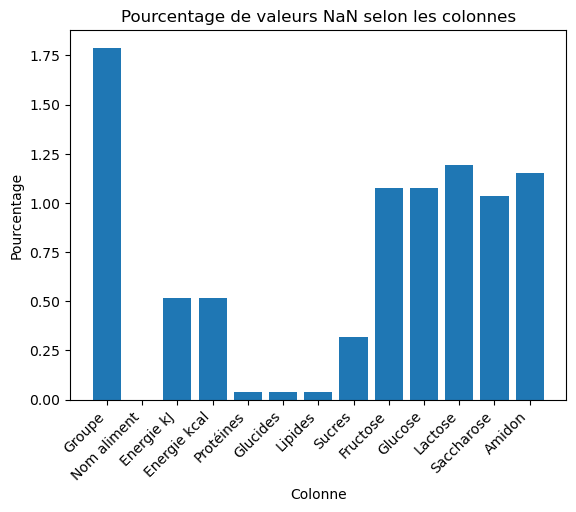

In [8]:
# Calcul des données manquantes selon les différentes colonnes

n = len(data_ciqual)
percentages = []
for col in (list(data_ciqual.columns)):
    percentages.append(((data_ciqual[col].isna()).sum()/n)*100)
plt.bar(data_ciqual.columns, percentages)
plt.xlabel('Colonne')
plt.ylabel('Pourcentage')
plt.xticks(rotation=45, ha='right')
plt.title('Pourcentage de valeurs NaN selon les colonnes')
plt.show()

Les valeurs principales qui nous intéressent sont dans un premier temps le nom des aliments étant donné que l'on veut un matching avec les noms d'aliments présents dans les recettes sur Marmiton. Dans un second temps, si nous voulons traiter l'apport énergétique nous nous intéresserons également à ces données. 
Les résultats sont donc très satisfaisants car il n'y a aucun nom d'aliment manquant et les apports sont manquants à hauteur de seulement 1%.

# **2. Simplification des ingrédients et normalisation (NLP)**

Afin de relier les ingrédients des recettes aux ingrédients de la base, nous devons nous assurer que les noms des ingrédients sont clairs et similaires à ceux des recettes. Nous vérifions donc qu'il n'existe pas de doublons ou d'ingrédients trop similaires dans la base Ciqual. Nous mettons ensuite en place des méthodes de distance pour comparer les ingrédients. 

La librairie **unidecode** sur Python permet de produire une représentation ASCII (American Standard Code for Information Interchange) d'un texte donné. Dans notre cas, elle va permettre de supprimer les accents sur les noms des aliments.

Afin d'identifier les mots superflus dans les noms d'aliments, on affiche un nuage de mots. 

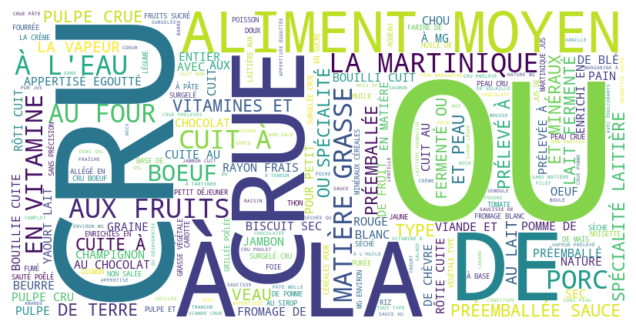

In [10]:
concat_aliments = ' '.join(data_ciqual["Nom aliment"].apply(lambda row : row.upper()))
cloud = WordCloud(width=800, height=400, background_color='white').generate(concat_aliments)
plt.figure(figsize=(8, 4))
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

On réalise qu'il y a pour le moment beaucoup de bruit dans les noms d'aliments, tel que **cru** ou **aliment**. On définit donc une liste de stopwords (qui ne doit pas être trop grande néanmoins car on veut pouvoir apparier les aliments avec ceux des recettes).

In [172]:
nltk.download('stopwords')
nltk.download('punkt')

def cleaning(s):
    stop_words_spe = ['CRU','CRUE','ALIMENT','TOUT','TYPE','PREEMBALLE','PREEMBALLEE','PREEMBALLEES','MOYEN','CUIT',
                      'CUITE','PETIT DEJEUNER','ROTI','ROTIE','FOUR','AU FOUR','KG','CL','G','L','MG','MARTINIQUE',
                      'VITAMINES','MINERAUX','PULPE','ENTIER','UHT','PASTEURISE','ENRICHI','SOUS PRESSION','VITAMINE','SEULEMENT'
                     ]
    stop_words_default = [s.upper() for s in stopwords.words('french')]
    stop_words = set(stop_words_default + stop_words_spe)
    s = unidecode(s)
    s = s.upper()
    s = sub("[^A-Z ]", " ", s)
    mots = word_tokenize(s)
    mots_filtres = [mot for mot in mots if mot not in stop_words]
    #from nltk.stem.snowball import FrenchStemmer
    #s = " ".join(FrenchStemmer().stem(s) for s in s.split())
    return ' '.join(mots_filtres)
    

# Apply the function to the column of ingredients' names 
data_ciqual["Nom clean"] = data_ciqual["Nom aliment"].apply(cleaning)
data_ciqual

[nltk_data] Downloading package stopwords to /Users/lila/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/lila/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,Groupe,Nom aliment,Energie kJ,Energie kcal,Protéines,Glucides,Lipides,Sucres,Fructose,Glucose,Lactose,Saccharose,Amidon,Nom clean,dist
0,NaN,Dessert (aliment moyen),NaN,NaN,"4,61","36,6","12,9","23,7","1,81","2,18","1,89","15,7","9,53",DESSERT,0.484127
338,"fruits, légumes, légumineuses et oléagineux","Avocat, pulpe, cru",843,205,"1,56","0,83","20,6","0,4","0,16","0,16","< 0,2","< 0,2","< 0,35",AVOCAT,0.000000
339,"fruits, légumes, légumineuses et oléagineux","Bette ou blette, crue","68,3","16,4",1,"1,63","< 0,5","1,2","0,5","0,7","< 0,2","< 0,2","< 0,35",BETTE BLETTE,0.611111
340,"fruits, légumes, légumineuses et oléagineux","Carotte, crue",169,"40,2","0,63","7,59","< 0,5",6,"0,9","1,1","< 0,2",4,"0,4",CAROTTE,0.000000
341,"fruits, légumes, légumineuses et oléagineux","Champignon, tout type, cru","91,2","21,7","2,37","1,88","0,23","1,43","0,17","0,82",0,"< 0,1",0,CHAMPIGNON,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3142,aides culinaires et ingrédients divers,"Pollen, partiellement séché",1510,358,"21,9","52,5","4,2","36,5",-,-,-,-,-,POLLEN PARTIELLEMENT SECHE,0.414530
3143,aides culinaires et ingrédients divers,"Pollen,frais",1200,285,"17,5","37,7","5,17","26,8",-,-,-,-,-,POLLEN FRAIS,0.444444
3144,aides culinaires et ingrédients divers,Base de pizza à la crème,1100,261,"7,7","51,1","2,6","1,8",-,-,-,-,-,BASE PIZZA A CREME,0.592593
3145,aides culinaires et ingrédients divers,Base de pizza tomatée,983,232,"6,9","44,6","2,7","1,5",-,-,-,-,-,BASE PIZZA TOMATEE,0.592593


In [173]:
result = data_ciqual[data_ciqual["Groupe"]=='produits laitiers et assimilés']
result

,Groupe,Nom aliment,Energie kJ,Energie kcal,Protéines,Glucides,Lipides,Sucres,Fructose,Glucose,Lactose,Saccharose,Amidon,Nom clean,dist
1929,produits laitiers et assimilés,"Lait entier, UHT",272,"65,1","3,25","4,85","3,63","4,2","< 0,3","< 0,3","4,2","< 0,3",0,LAIT,0.433333
1930,produits laitiers et assimilés,"Lait entier, pasteurisé",236,"56,5","3,23","3,47","3,3",-,"< 0,2","< 0,2","3,2","< 0,2","< 0,2",LAIT,0.419192
1931,produits laitiers et assimilés,"Lait demi-écrémé, UHT, enrichi en vitamine D s...",196,"46,6","3,31","4,8","1,52","4,5","< 0,2","< 0,2","4,5","< 0,2",0,LAIT DEMI ECREME,0.403073
1932,produits laitiers et assimilés,"Lait à 1,2% de matière grasse, UHT, enrichi en...",186,"44,1","3,31","4,79","1,25","4,5","< 0,2","0,2",4,"< 0,2",0,LAIT A MATIERE GRASSE PLUSIEURS,0.578811
1933,produits laitiers et assimilés,"Lait, teneur en matière grasse inconnue, UHT (...",199,"47,3","3,32","4,82","1,59","4,62","0,059","0,059","4,62","0,059",0,LAIT TENEUR MATIERE GRASSE INCONNUE,0.405983
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2225,produits laitiers et assimilés,"Crème chantilly, sous pression, UHT",1270,308,"2,06","10,6","28,2","10,4","< 0,1","< 0,1","2,73","7,68",-,CREME CHANTILLY SOUS PRESSION,0.575758
2226,produits laitiers et assimilés,"Crème de lait, 15 à 20% MG, légère, semi-épais...",798,194,"2,56","2,89","18,7","2,89","< 0,1","< 0,1","2,89","< 0,1",0,CREME LAIT A LEGERE SEMI EPAISSE,0.574074
2227,produits laitiers et assimilés,"Crème de lait, 15 à 20% MG, légère, épaisse, r...",684,166,"2,75",3,"15,3",3,"< 0,1","< 0,1",3,"< 0,1",0,CREME LAIT A LEGERE EPAISSE RAYON FRAIS,0.572650
2228,produits laitiers et assimilés,"Spécialité à base de crème légère 8% MG, fluid...",318,"76,2","3,19","5,28","4,3","4,44","< 0,1","< 0,1","4,25","0,19",-,SPECIALITE A BASE CREME LEGERE FLUIDE EPAISSE,0.688889


On affiche le nouveau nuage de mots, plus clair cette fois ! 

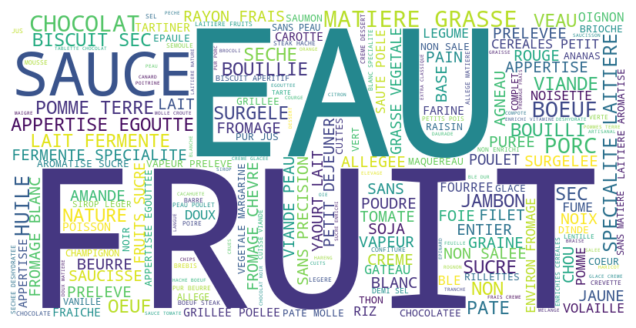

In [38]:
concat_aliments = ' '.join(data_ciqual["Nom clean"])
cloud = WordCloud(width=800, height=400, background_color='white').generate(concat_aliments)
plt.figure(figsize=(8, 4))
plt.imshow(cloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Distance entre les aliments de Ciqual et la recette

En première approche, nous décidons d'utiliser la **distance de Levenshtein** à l'aide du package rapidfuzz de python. 

In [39]:
rapidfuzz.distance.Levenshtein.distance('sucre blanc','sucre roux', weights =(1,1,1))

5

## Matching avec les ingrédients de la recette 

On crée ensuite une fonction qui associe à chaque ingrédient de la recette, les ingrédients présents dans la base de données et leur apport calorique.

In [131]:

import numpy as np
import spacy 
from scipy.spatial.distance import cosine
from unidecode import unidecode

nlp2 = spacy.load('fr_core_news_sm')
vectors2 = np.array([nlp2(aliment).vector for aliment in data_ciqual["Nom clean"] if nlp2(aliment).vector.any()])     #Vectorisation des aliments de la base Ciqual par le modèle fr_core_news_sm#

def trouver_correspondance_spacy2(aliment_entre, dataframe, vec, seuil):
    # Vectoriser le nouvel aliment
    vecteur_aliment_entre = nlp2(aliment_entre).vector
    
    # Vérifier si vectors2 est vide
    if len(vec) == 0:
        return "Aucun vecteur n'est disponible dans "+ vec
    
    # Calculer la similarité cosinus avec tous les vecteurs d'aliments existants
    similarites = np.array([1 - cosine(vecteur_aliment_entre, vecteur) for vecteur in vec])
    
    # Trouver la correspondance la plus proche
    index_correspondance = similarites.argmax()
    score_correspondance = similarites[index_correspondance]
    
    # Si le score est supérieur au seuil, retourner la correspondance
    if score_correspondance >= seuil:
        return dataframe["Nom clean"].iloc[index_correspondance]
    else:
        return "Aucune correspondance trouvée"


In [45]:
trouver_correspondance_spacy2("AVOCAT",data_ciqual,vectors2,0.8)

'AVOCAT'

In [136]:
l_test = ['1 pincée\nde sel', "1 bonne cuillère à café\nd' extrait de vanille liquide", '1 sachet\nde levure chimique', "10 cl\nd' huile", '180 g\nde sucre blanc ou sucre de canne', '160 g\nde farine de châtaigne', '10 cl\nde lait', '4\noeufs', "5 cl\nd' eau de vie ou de rhum"]
print(l_test)

['1 pincée\nde sel', "1 bonne cuillère à café\nd' extrait de vanille liquide", '1 sachet\nde levure chimique', "10 cl\nd' huile", '180 g\nde sucre blanc ou sucre de canne', '160 g\nde farine de châtaigne', '10 cl\nde lait', '4\noeufs', "5 cl\nd' eau de vie ou de rhum"]


In [194]:
import re 
from unidecode import unidecode
from conversions_unites import liquides_en_ml, solides_en_g

def cleaning(s):
    from unidecode import unidecode 
    stop_words_spe = ['CRU','CRUE','ALIMENT','TOUT','TYPE','PREEMBALLE','PREEMBALLEE','PREEMBALLEES','MOYEN','CUIT',
                      'CUITE','PETIT DEJEUNER','ROTI','ROTIE','FOUR','AU FOUR','KG','CL','G','L','MG','MARTINIQUE',
                      'VITAMINES','MINERAUX'
                     ]
    stop_words_default = [s.upper() for s in stopwords.words('french')]
    stop_words = set(stop_words_default + stop_words_spe)
    s = unidecode(s)
    s = s.upper()
    s = sub("[^A-Z ]", " ", s)
    mots = word_tokenize(s)
    mots_filtres = [mot for mot in mots if mot not in stop_words]
    #from nltk.stem.snowball import FrenchStemmer
    #s = " ".join(FrenchStemmer().stem(s) for s in s.split())
    return ' '.join(mots_filtres)


def conversion_recette(liste_ingredients):
    """
    Cette fonction prend la liste des ingredients retournée par le scraper de marmiton pour une recette donnée, et renvoie les ingrédients ainsi que leur conversion 

    Args : 
        liste_ingredients (list of str) : liste d'ingredients issus de la page marmiton de la recette 

    Returns : 
        Dict : avec comme clé l'ingrédient et comme valeur (quantité,unité de mesure) ou (quantité)
    
    """
    res = {} # dictionnaire resultat  
   
    # Pour les elements type : quantité DE ingrédient (ex : 1 pincée DE sel)
    pattern_1 = re.compile(r'(\d+)\s*(bonne cuillère à café|cuillère à café|cuillère à soupe|ml|l|kg|g|cl|cuillère|pincée|sachet)\s*de\s*([\w\s]+)')
   
    # Pour les elements type : quantité D' ingrédient (ex : 10 cl D'huile) 
    pattern_2 = re.compile(r'(\d+)\s*(bonne cuillère à café|cuillère à café|cuillère à soupe|ml|l|kg|g|cl|cuillère|pincée|sachet)\s*d\'\s*([\w\s]+)')
    
    # Pour les elements type : quantité ingrédient (ex : 4 oeufs)
    pattern_3 = re.compile(r'(\d+)\s*([\w\s]+)')  
    fail =[]

    for elt in l_test : 

        qtte,nom = elt.split('\n')
        ingredient = qtte+" "+nom 

        if pattern_1.match(ingredient):
            match = pattern_1.match(ingredient)
            quantity = match.group(1)
            unit = match.group(2)
            ingredient_name = match.group(3)
            res[cleaning(ingredient_name)] = (string_to_float(quantity),unidecode(unit.upper()))
        
        elif pattern_2.match(ingredient):
            match = pattern_2.match(ingredient)
            quantity = match.group(1)
            unit = match.group(2)
            ingredient_name = match.group(3)
            res[cleaning(ingredient_name)] = (string_to_float(quantity),unidecode(unit.upper()))
        
        elif pattern_3.match(ingredient):
            match = pattern_3.match(ingredient)
            quantity = match.group(1)
            ingredient_name = match.group(2)
            res[cleaning(ingredient_name)] = (string_to_float(quantity),"UNITE") # Pour les elements comme "1 oeuf"
        
        else: # si l'ingredient ne correspond à aucun des patterns précédents 
            fail.append(elt)
    nv_res = {}
    for ingr,(qtte,unite) in res.items():
        if unite == "UNITE":
            nv_res[ingr] = qtte
        else :
            if unite in liquides_en_ml:
                nv_res[ingr] = liquides_en_ml[unite]*qtte
            elif unite in solides_en_g:
                nv_res[ingr] = solides_en_g[unite]*qtte
            else: #cas où l'ingrédient est déjà en g ou dans la bonne unité
                nv_res[ingr] = qtte 
    return(nv_res,fail)

print(conversion_recette(l_test))
print(l_test)


({'SEL': 1.0, 'EXTRAIT VANILLE LIQUIDE': 0.5, 'LEVURE CHIMIQUE': 11.0, 'HUILE': 100.0, 'SUCRE BLANC SUCRE CANNE': 180.0, 'FARINE CHATAIGNE': 160.0, 'LAIT': 100.0, 'OEUFS': 4.0, 'EAU VIE RHUM': 50.0}, [])
['1 pincée\nde sel', "1 bonne cuillère à café\nd' extrait de vanille liquide", '1 sachet\nde levure chimique', "10 cl\nd' huile", '180 g\nde sucre blanc ou sucre de canne', '160 g\nde farine de châtaigne', '10 cl\nde lait', '4\noeufs', "5 cl\nd' eau de vie ou de rhum"]


In [ ]:


def 

1.5